# Covid-19 Case Prediction in Malaysia  
## Introduction  

### Objective  
The objective of this project is to **predict next week’s daily Covid-19 cases in Malaysia** using supervised learning models.  

This regression problem will be approached using **three supervised learning methods**:  
1. Linear Regression  
2. K-Nearest Neighbors (KNN) Regressor  
3. Decision Tree Regressor  

### Motivation  
- Predicting Covid-19 cases 7 days ahead helps governments and healthcare authorities prepare for surges.  
- Accurate predictions can inform **hospital readiness, vaccination campaigns, and policy interventions**.  
- By comparing different machine learning models, we aim to evaluate which method balances **prediction accuracy and computational efficiency**.  

### Dataset  
Source: [Ministry of Health Malaysia (MoH) GitHub Repository](https://github.com/MoH-Malaysia/covid19-public)  

We will use **country-level daily data**:  
- Daily new cases  
- Testing numbers  
- Hospital & ICU utilization  
- Vaccination progress  

We will use a **6-month consecutive date range**, starting from `START_DATE` (e.g., March 1, 2022).  
- End date will be computed automatically as **6 months after start**.  
- This ensures enough samples for training and testing while remaining focused on a meaningful period.  

### Methodology Overview  
The notebook will follow these steps:  
1. **Data Collection & Cleaning** – Load datasets and preprocess  
2. **Feature Engineering** – Transform and scale features for modeling  
3. **Dataset Splitting** – Train, validation, and test sets  
4. **Model Training, Tuning & Evaluation** – Train, tune and evaluate Linear Regression, KNN Regressor, and Decision Tree Regressor  
5. **Analysis & Conclusion** – Compare model performance and summarize findings  

In [102]:
# --- Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

# --- Set constants ---
START_DATE = pd.to_datetime("2022-03-01")
END_DATE = START_DATE + pd.DateOffset(months=6) - pd.Timedelta(days=1)


# Part 1: Data Collection & Cleaning

### Data Source
We will use official Malaysian Covid-19 datasets provided by the **Ministry of Health Malaysia (MoH)**, available on GitHub:  
[https://github.com/MoH-Malaysia/covid19-public](https://github.com/MoH-Malaysia/covid19-public)

### Selected Files
For this project, we will mainly use:
1. `cases_malaysia.csv` → Daily Covid-19 cases (our primary target variable)  
2. `tests_malaysia.csv` → Daily testing numbers  
3. `hospital.csv` → Hospitalization data  
4. `icu.csv` → ICU utilization data  
5. `vax_malaysia.csv` → Vaccination progress  

### Target Variable
- Our target variable for regression is `cases_new`, i.e., the **number of new Covid-19 cases per day**.


In [103]:
# --- Read the CSV files ---
datasets = {
    "cases": pd.read_csv("cases_malaysia.csv"),
    "tests": pd.read_csv("tests_malaysia.csv"),
    "hospital": pd.read_csv("hospital.csv"),
    "icu": pd.read_csv("icu.csv"),
    "vax": pd.read_csv("vax_malaysia.csv"),
}

# --- Data Cleaning ---
for name, df in datasets.items():
    # Convert date column to datetime
    df["date"] = pd.to_datetime(df["date"])
    
    # Filter to 6-month range
    df = df[(df["date"] >= START_DATE) & (df["date"] <= END_DATE)].copy()
    
    # Drop empty cluster columns in cases dataset
    if name == "cases":
        cluster_cols = [
            "cluster_import", "cluster_religious", "cluster_community",
            "cluster_highRisk", "cluster_education", "cluster_detectionCentre",
            "cluster_workspace"
        ]
        df.drop(columns=cluster_cols, inplace=True, errors="ignore")
    
    # Aggregate numeric columns by date
    df = df.groupby("date").sum(numeric_only=True).reset_index()
    
    # Drop columns with a single unique value
    nunique = df.nunique()
    cols_to_drop = nunique[nunique <= 1].index
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")
    
    # Fill missing values with 0
    df.fillna(0, inplace=True)
    
    # Save cleaned dataset
    datasets[name] = df

# --- Merge all datasets on date ---
from functools import reduce
df = reduce(lambda left, right: pd.merge(left, right, on="date", how="left"), datasets.values())

# --- Sort by date ---
df = df.sort_values("date").reset_index(drop=True)

# --- Display cleaned dataset ---
df


,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,sinopharm2,sinopharm3,sinopharm4,cansino,cansino3,cansino4,pending1,pending2,pending3,pending4
0,2022-03-01,25854,448,25548,293658,484,4055,372,9417,12010,...,15,19,0,33,34,1,3,0,3,1
1,2022-03-02,27500,428,27557,293486,362,4392,484,9699,12925,...,12,4,0,54,15,0,0,0,17,0
2,2022-03-03,32467,413,27629,298238,472,4966,579,11486,15436,...,10,13,0,49,12,0,0,0,18,1
3,2022-03-04,33209,441,26352,305017,472,5160,615,10959,16475,...,6,61,0,74,12,0,6,0,1,0
4,2022-03-05,33406,342,27143,311213,394,4897,617,10842,17050,...,8,242,1,158,16,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2022-08-27,2491,0,3715,34515,1,240,8,533,1710,...,1,0,0,0,0,0,0,0,0,0
180,2022-08-28,2191,1,3796,32908,3,220,10,432,1529,...,0,0,0,0,0,0,0,0,0,0
181,2022-08-29,1946,1,3271,31575,20,247,8,399,1292,...,2,3,1,0,0,0,0,0,0,0
182,2022-08-30,2144,3,2549,31166,8,204,12,480,1448,...,1,0,0,0,0,0,0,0,1,0


# Part 2: Feature Engineering

We organize feature engineering into three subparts:

1. **Feature Selection** – select relevant numerical metrics and drop redundant or noisy columns.  
2. **Feature Transformation** – scale features and handle skewed distributions to improve model performance.  
3. **Feature Creation (Lagging)** – create lag features from the past 7–14 days to predict next week's cases.

### Part 2.1: Feature Selection

**Objective:** Reduce noise and prevent overfitting by selecting relevant numerical features.

**Reasoning:**
- Drop highly detailed or redundant columns that are unlikely to improve prediction accuracy:
  - **Case breakdowns** by age or vaccination type (correlated with total cases)
  - **ICU/ventilator subcategories** (aggregated in broader metrics)
  - **Vaccination subgroups** (aggregated)
  - **Date column** to avoid leakage
- This ensures the model focuses on metrics most predictive of next week’s Covid-19 cases.

In [104]:
# --- Feature Selection ---

features_to_drop = [
    # Date
    'date',
    
    # Cases breakdowns
    'cases_import', 'cases_recovered', 'cases_cluster', 'cases_pvax', 'cases_fvax',
    'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly',
    'cases_0_4', 'cases_5_11', 'cases_12_17', 'cases_18_29', 'cases_30_39',
    'cases_40_49', 'cases_50_59', 'cases_60_69', 'cases_70_79', 'cases_80',
    
    # Hospital / ICU subcategories
    'admitted_pui', 'admitted_covid', 'admitted_total', 'discharged_pui', 'discharged_covid', 
    'discharged_total', 'hosp_covid', 'hosp_pui', 'hosp_noncovid', 'beds_icu_rep', 
    'beds_icu_total', 'beds_icu_covid', 'icu_pui', 'icu_noncovid', 'vent_covid', 
    'vent_pui', 'vent_noncovid', 'vent_used', 'vent_port_used',
    
    # Vaccination subgroups
    'daily_partial_adol', 'daily_full_adol', 'daily_partial_child', 'daily_full_child',
    'cumul_partial_adol', 'cumul_full_adol', 'cumul_partial_child', 'cumul_full_child',
    'pfizer1', 'pfizer2', 'pfizer3', 'sinovac1', 'sinovac2', 'sinovac3', 'astra1', 
    'astra2', 'sinopharm1', 'sinopharm2', 'cansino', 'pending1', 'pending2', 'pending3'
]

# Select relevant features
features = df.drop(columns=features_to_drop, errors="ignore")
print("Selected features for modeling:", features.columns.tolist())


Selected features for modeling: ['cases_new', 'cases_active', 'cases_unvax', 'cases_boost', 'rtk-ag', 'pcr', 'beds', 'beds_covid', 'beds_noncrit', 'beds_icu', 'vent', 'vent_port', 'icu_covid', 'daily_partial', 'daily_full', 'daily_booster', 'daily_booster2', 'daily', 'daily_booster_adol', 'daily_booster2_adol', 'daily_booster_child', 'daily_booster2_child', 'cumul_partial', 'cumul_full', 'cumul_booster', 'cumul_booster2', 'cumul', 'cumul_booster_adol', 'cumul_booster2_adol', 'cumul_booster_child', 'cumul_booster2_child', 'pfizer4', 'sinovac4', 'astra3', 'astra4', 'sinopharm3', 'sinopharm4', 'cansino3', 'cansino4', 'pending4']


### Part 2.2: Feature Transformation

**Objective:** Transform features to improve model performance by:

1. **Scaling:** Using `StandardScaler` so features are comparable for distance-based methods (KNN) and regression optimization.
2. **Handling skewed distributions:** Apply log transformation to reduce the effect of extreme values.

**Reasoning:**  
- Without scaling, features with large ranges dominate KNN distance calculations and regression weight updates.  
- Skewed features can bias the model toward outliers. Log transformation stabilizes learning and improves convergence.


In [105]:
# --- Log-transform to reduce skewness ---
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
X_log = log_transformer.fit_transform(features)  # fit_transform to compute on dataset

# --- Standard scaling ---
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_log)

# --- Update features for modeling ---
X = pd.DataFrame(X_scaled, columns=features.columns)
print("Feature matrix shape after transformations:", X.shape)
print("Data types:\n", X.dtypes.value_counts())


Feature matrix shape after transformations: (184, 40)
Data types:
 float64    40
Name: count, dtype: int64


### Part 2.3: Feature Visualization

**Objective:** Visualize feature distributions to understand the effect of **feature selection** and **transformations** on the data.

**Reasoning:**  
1. Comparing distributions **before and after feature engineering** helps identify skewed features.  
2. Assess the impact of dropping irrelevant columns and verify scaling and log transformation.  
3. Helps determine if additional transformations may be needed before modeling.


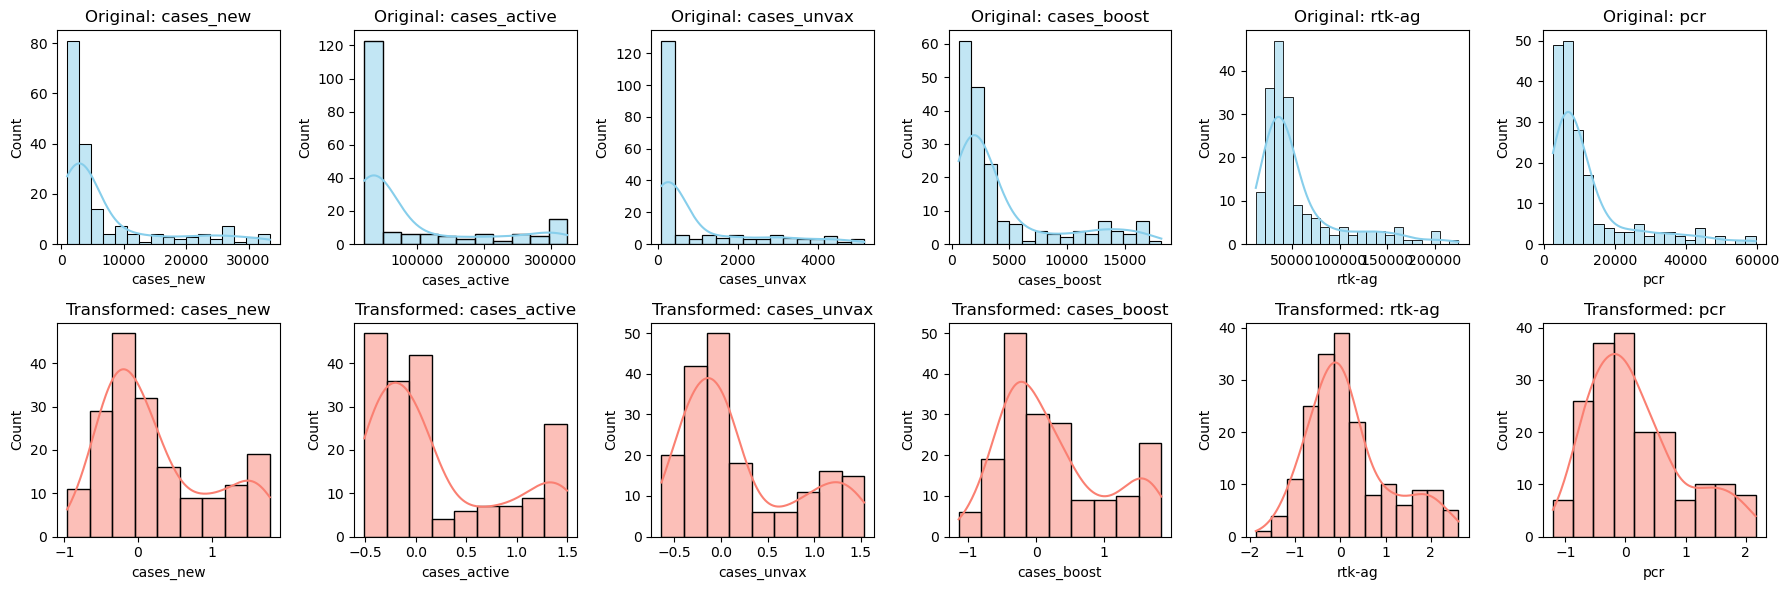

In [106]:
# --- Feature Visualization ---

# Original features before selection
original_features = df.drop(columns=['date'], errors="ignore")  # no classification target now

# Features after selection and transformations (Part 2.1 & 2.2)
processed_features = X.copy()

# Plot distributions before and after feature engineering
num_features_to_plot = min(6, len(processed_features.columns))  # plot a few examples
sample_cols = processed_features.columns[:num_features_to_plot]

plt.figure(figsize=(18, 6))

for i, col in enumerate(sample_cols, 1):
    # Original distribution
    plt.subplot(2, num_features_to_plot, i)
    sns.histplot(original_features[col], kde=True, color='skyblue')
    plt.title(f'Original: {col}')
    
    # Transformed distribution
    plt.subplot(2, num_features_to_plot, i + num_features_to_plot)
    sns.histplot(processed_features[col], kde=True, color='salmon')
    plt.title(f'Transformed: {col}')

plt.tight_layout()
plt.show()


### Part 2.4: Feature Creation (Lagging)

**Objective:** Create lag features from the past 8–14 days to predict **next week's Covid-19 cases**.

**Reasoning:**  
1. Using data from 8–14 days prior captures **recent trends** without using future data (prevents look-ahead bias).  
2. Shifting the target 7 days forward aligns with **next week’s prediction**.  
3. Lagged features help models like KNN, Linear Regression, and Decision Trees capture temporal patterns in the data.


In [107]:
# --- Create lagged features ---
lag_data = {}
start_lag = 7
end_lag = 10

for col in X.columns:
    for lag in range(start_lag, end_lag + 1):
        lag_data[f"{col}_lag{lag}"] = X[col].shift(lag)

# Convert to DataFrame
lagged_features = pd.DataFrame(lag_data)
lagged_features["date"] = df["date"]

# Shift target (cases_new) backward by 7 days to represent next week's cases
y = df["cases_new"].shift(-7)

# Combine lagged features with target
df_weekly = pd.concat([lagged_features, y.rename("cases_next_week")], axis=1)

# Drop rows with NaNs created by shifting
df_weekly = df_weekly.dropna().reset_index(drop=True)

# Final dataset for modeling
X_final = df_weekly.drop(columns=["date", "cases_next_week"])
y_final = df_weekly["cases_next_week"]

print("Feature matrix shape:", X_final.shape)
print("Target vector shape:", y_final.shape)


Feature matrix shape: (167, 160)
Target vector shape: (167,)


## Part 3: Splitting the Dataset

**Objective:**  
Split the processed dataset into **training**, **validation**, and **testing sets** for model training, hyperparameter tuning, and final evaluation.

**Reasoning:**  
1. The data is **time-series** (daily Covid-19 cases with lag features), so **random shuffling is avoided** to prevent data leakage.  
2. We use a **chronological split**:  
   1. **Training set:** First 60% → used to learn patterns.  
   2. **Validation set:** Next 20% → used to tune hyperparameters of Linear Regression, KNN, and Decision Tree Regression.  
   3. **Testing set:** Final 20% → held-out set for evaluating model performance on unseen data.  
3. This approach ensures **generalization** and simulates real-world forecasting, where predictions are always based on **past data**.


Train shape: (100, 160) (100,)
Validation shape: (33, 160) (33,)
Test shape: (34, 160) (34,)


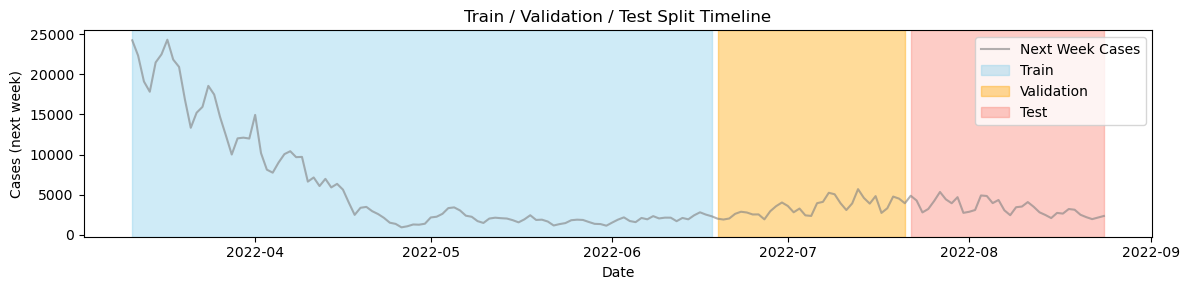

In [108]:
# Keep the date column for plotting
dates = df_weekly["date"]

# Chronological split
n = len(X_final)
train_size = int(0.6 * n)
val_size = int(0.2 * n)

# Training set (first 60%)
X_train = X_final.iloc[:train_size]
y_train = y_final.iloc[:train_size]
dates_train = dates.iloc[:train_size]

# Validation set (next 20%)
X_val = X_final.iloc[train_size:train_size + val_size]
y_val = y_final.iloc[train_size:train_size + val_size]
dates_val = dates.iloc[train_size:train_size + val_size]

# Testing set (final 20%)
X_test = X_final.iloc[train_size + val_size:]
y_test = y_final.iloc[train_size + val_size:]
dates_test = dates.iloc[train_size + val_size:]

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

# Visualization of splits
plt.figure(figsize=(12, 3))
plt.plot(dates, y_final, label="Next Week Cases", color="gray", alpha=0.6)

plt.axvspan(dates_train.min(), dates_train.max(), color="skyblue", alpha=0.4, label="Train")
plt.axvspan(dates_val.min(), dates_val.max(), color="orange", alpha=0.4, label="Validation")
plt.axvspan(dates_test.min(), dates_test.max(), color="salmon", alpha=0.4, label="Test")

plt.title("Train / Validation / Test Split Timeline")
plt.xlabel("Date")
plt.ylabel("Cases (next week)")
plt.legend()
plt.tight_layout()
plt.show()


## Part 4: Model Training, Tuning & Evaluation

**Objective:**  
Train, tune, and evaluate regression models to **predict the number of Covid-19 cases for the following week** using lagged features. This part combines **model training**, **hyperparameter tuning**, and **evaluation** for all models.

### Supervised Learning Methods & Hyperparameters

We will use the following three regression methods:

1. **Linear Regression**  
   - Hyperparameters to tune:
     1. `regularization` → None, Ridge (L2), Lasso (L1), ElasticNet  
     2. `alpha` → Regularization strength (for Ridge/Lasso/ElasticNet)  
     3. `l1_ratio` → Balance between L1 and L2 (for ElasticNet)  
     4. `fit_intercept` → Include or exclude intercept  
     5. `positive` → Restrict coefficients to be positive  
     6. `max_iter` → Maximum iterations for convergence (for Lasso/ElasticNet)

2. **K-Nearest Neighbors (KNN) Regression**  
   - Hyperparameters to tune:
     1. `n_neighbors` → Number of neighbors  
     2. `weights` → Uniform or distance-based weighting  
     3. `metric` → Distance metric (e.g., Euclidean, Manhattan)  
     4. `p` → Power parameter for Minkowski metric  

3. **Decision Tree Regression**  
   - Hyperparameters to tune:
     1. `max_depth` → Maximum depth of the tree  
     2. `min_samples_split` → Minimum samples required to split a node  
     3. `min_samples_leaf` → Minimum samples required for a leaf node  
     4. `max_features` → Maximum features considered for splits  

**Notes:**  
- Features are **log-transformed and standardized** to improve numerical stability and convergence.  
- Chronological splits prevent **data leakage**, ensuring future information is never used in training.

### Evaluation Metrics

Each model will be assessed on the **validation and test sets** using:

1. **Mean Squared Error (MSE)** – Average squared difference between predicted and actual cases  
2. **Root Mean Squared Error (RMSE)** – Square root of MSE, interpretable in the same units as cases  
3. **Mean Absolute Error (MAE)** – Average absolute difference between predictions and true values  
4. **R² Score** – Proportion of variance explained by the model; indicates goodness of fit  
5. **Training Time** – Duration of model training to compare computational efficiency

### Visualization Plan

To understand model performance and behavior:

1. **Predicted vs Actual Plot** – Compare predicted weekly cases against actual numbers  
2. **Residual Plot** – Show distribution of prediction errors to detect bias or heteroscedasticity  
3. **Training vs Validation Curve** – Assess underfitting/overfitting across hyperparameter choices  
4. **Comparison Bar Plot** – Summarize RMSE, MAE, R², and training time for all models for quick comparison


In [109]:
# Train a model and measure training time
def train_model(model, X_train, y_train):
    """
    Fit a model on the training data and return training time.
    """
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    return end_time - start_time

# Compute regression evaluation metrics
def evaluate_model(model, X, y_true):
    """
    Evaluate a trained regression model and return a dictionary of metrics.
    """
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }
    return metrics, y_pred

# Plot Predicted vs Actual
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure(figsize=(4, 3))
    sns.scatterplot(x=y_true, y=y_pred, color="teal", alpha=0.7)
    max_val = max(max(y_true), max(y_pred))
    plt.plot([0, max_val], [0, max_val], color="red", linestyle="--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot Residuals
def plot_residuals(y_true, y_pred, title="Residual Plot"):
    residuals = y_true - y_pred
    plt.figure(figsize=(4, 3))
    sns.scatterplot(x=y_pred, y=residuals, color="orange", alpha=0.7)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Run full regression pipeline including train, validation, and test metrics
def run_full_regression_pipeline(
    model,
    param_grid,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    cv=3,
    scoring="neg_mean_squared_error",
    model_name="Model"
):
    """
    Train, tune, evaluate on training, validation, and test sets, and produce plots.
    
    Returns:
    - best_model: trained best estimator
    - metrics_train: evaluation metrics on training set
    - metrics_val: evaluation metrics on validation set
    - metrics_test: evaluation metrics on test set
    - train_time: training duration
    """
    print(f"=== {model_name} ===")
    
    # 1. Hyperparameter tuning & training
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
    train_time = train_model(grid, X_train, y_train)
    best_model = grid.best_estimator_
    
    print("Best Parameters:", grid.best_params_)
    print(f"Training Time: {train_time:.2f} seconds")
    
    # 2. Evaluate on training set
    metrics_train, y_train_pred = evaluate_model(best_model, X_train, y_train)
    print("Training Metrics:", metrics_train)
    
    # 3. Evaluate on validation set
    metrics_val, y_val_pred = evaluate_model(best_model, X_val, y_val)
    print("Validation Metrics:", metrics_val)
    
    # 4. Evaluate on test set
    metrics_test, y_test_pred = evaluate_model(best_model, X_test, y_test)
    print("Test Metrics:", metrics_test)
    
    # 5. Visualizations
    plot_predicted_vs_actual(y_test, y_test_pred, title=f"{model_name} Test: Predicted vs Actual")
    plot_residuals(y_test, y_test_pred, title=f"{model_name} Test: Residuals")
    
    return best_model, metrics_train, metrics_val, metrics_test, train_time

# Example dictionary to store results
all_results = {}


### 4.1 Linear Regressions

=== Linear Regression ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'fit_intercept': False, 'positive': False}
Training Time: 0.12 seconds
Training Metrics: {'MSE': 2.630601076510846e-22, 'RMSE': 1.6219127832626653e-11, 'MAE': 1.2770442481269128e-11, 'R2': 1.0}
Validation Metrics: {'MSE': 21107859.180193335, 'RMSE': 4594.329023937373, 'MAE': 3677.1241615084914, 'R2': -19.276621806308373}
Test Metrics: {'MSE': 93161016.37751244, 'RMSE': 9651.995460914413, 'MAE': 9041.057767119415, 'R2': -105.78345180505663}


c:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_base.py", line 647, in fit
    self.coef_ = optimize

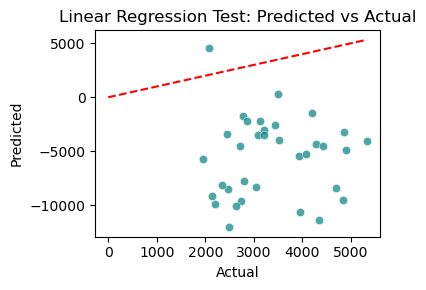

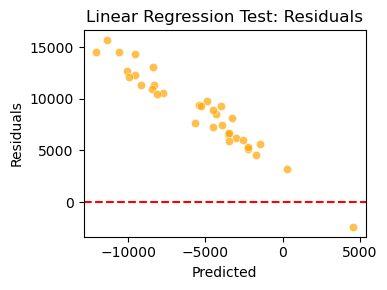

=== Ridge Regression ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'alpha': 0.01, 'fit_intercept': False, 'positive': False}
Training Time: 0.08 seconds
Training Metrics: {'MSE': 24217.821015291604, 'RMSE': 155.62076023234047, 'MAE': 120.18666814708249, 'R2': 0.999438365782655}
Validation Metrics: {'MSE': 23330993.968793415, 'RMSE': 4830.216762091885, 'MAE': 3897.209410951686, 'R2': -21.412208506412473}
Test Metrics: {'MSE': 74543053.97896104, 'RMSE': 8633.831940625265, 'MAE': 7987.243490571851, 'R2': -84.44308468800182}


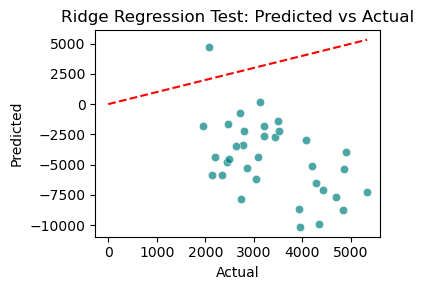

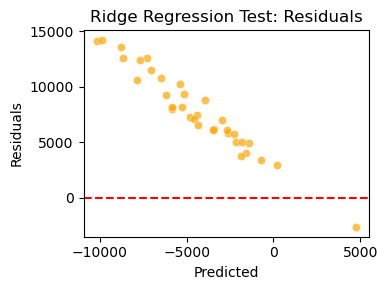

=== Lasso Regression ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'alpha': 0.01, 'fit_intercept': False, 'max_iter': 50000, 'positive': False}
Training Time: 2.50 seconds
Training Metrics: {'MSE': 8307.083167315472, 'RMSE': 91.14320143222682, 'MAE': 70.73565328291838, 'R2': 0.9998073508698347}
Validation Metrics: {'MSE': 33318519.692536224, 'RMSE': 5772.219650406265, 'MAE': 4528.763578877324, 'R2': -31.00642079257073}
Test Metrics: {'MSE': 28881710.275682706, 'RMSE': 5374.170659337374, 'MAE': 4180.5109878433195, 'R2': -32.10492776048568}


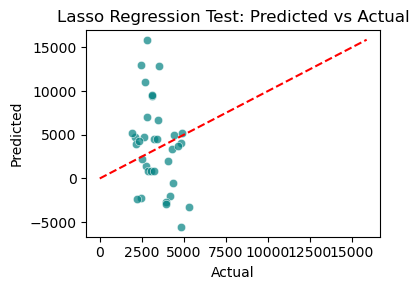

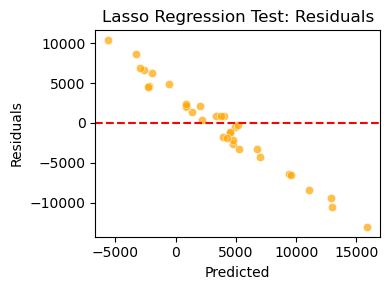

=== ElasticNet Regression ===
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.7, 'max_iter': 50000, 'positive': False}
Training Time: 6.41 seconds
Training Metrics: {'MSE': 204799.52477092153, 'RMSE': 452.5478149001733, 'MAE': 360.47242820514, 'R2': 0.9952505049593555}
Validation Metrics: {'MSE': 2248840.5645027724, 'RMSE': 1499.6134716995484, 'MAE': 1257.1250402284486, 'R2': -1.1602801705203576}
Test Metrics: {'MSE': 25064391.81243027, 'RMSE': 5006.435040268701, 'MAE': 4009.4451218939776, 'R2': -27.72942330598873}


c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.378e+06, tolerance: 4.312e+05
  model = cd_fast.enet_coordinate_descent(


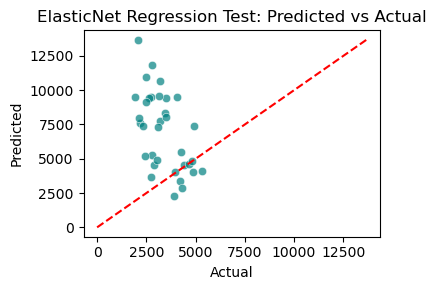

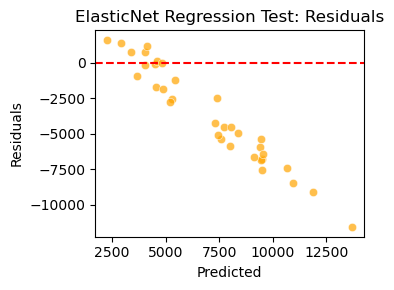

In [110]:
# Linear Regression (Ordinary Least Squares)
linear_params = {"fit_intercept": [True, False], "positive": [True, False]}
best_linear, metrics_train_linear, metrics_val_linear, metrics_test_linear, t_linear = run_full_regression_pipeline(
    LinearRegression(), linear_params, X_train, y_train, X_val, y_val, X_test, y_test, model_name="Linear Regression"
)
all_results["Linear"] = {
    "Train": metrics_train_linear,
    "Validation": metrics_val_linear,
    "Test": metrics_test_linear,
    "Train Time": t_linear
}

# Ridge Regression
ridge_params = {"alpha": [0.01, 0.1, 1, 10], "fit_intercept": [True, False], "positive": [True, False]}
best_ridge, metrics_train_ridge, metrics_val_ridge, metrics_test_ridge, t_ridge = run_full_regression_pipeline(
    Ridge(), ridge_params, X_train, y_train, X_val, y_val, X_test, y_test, model_name="Ridge Regression"
)
all_results["Ridge"] = {
    "Train": metrics_train_ridge,
    "Validation": metrics_val_ridge,
    "Test": metrics_test_ridge,
    "Train Time": t_ridge
}

# Lasso Regression
lasso_params = {"alpha": [0.01, 0.1, 1, 10], "fit_intercept": [True, False], "positive": [True, False], "max_iter": [50000]}
best_lasso, metrics_train_lasso, metrics_val_lasso, metrics_test_lasso, t_lasso = run_full_regression_pipeline(
    Lasso(), lasso_params, X_train, y_train, X_val, y_val, X_test, y_test, model_name="Lasso Regression"
)
all_results["Lasso"] = {
    "Train": metrics_train_lasso,
    "Validation": metrics_val_lasso,
    "Test": metrics_test_lasso,
    "Train Time": t_lasso
}

# ElasticNet Regression
elasticnet_params = {
    "alpha": [0.01, 0.1, 1, 10],
    "l1_ratio": [0.3, 0.5, 0.7],
    "fit_intercept": [True, False],
    "positive": [True, False],
    "max_iter": [50000]
}
best_elastic, metrics_train_elastic, metrics_val_elastic, metrics_test_elastic, t_elastic = run_full_regression_pipeline(
    ElasticNet(), elasticnet_params, X_train, y_train, X_val, y_val, X_test, y_test, model_name="ElasticNet Regression"
)
all_results["ElasticNet"] = {
    "Train": metrics_train_elastic,
    "Validation": metrics_val_elastic,
    "Test": metrics_test_elastic,
    "Train Time": t_elastic
}


### 4.2 KNN Regression

=== KNN Regression ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Training Time: 0.09 seconds
Training Metrics: {'MSE': 0.0, 'RMSE': 0.0, 'MAE': 0.0, 'R2': 1.0}
Validation Metrics: {'MSE': 2491447.1953176563, 'RMSE': 1578.4318785800217, 'MAE': 1276.3082677021116, 'R2': -1.3933328386636088}
Test Metrics: {'MSE': 1997494.423770386, 'RMSE': 1413.327429780653, 'MAE': 1105.81501926168, 'R2': -1.289577312759346}


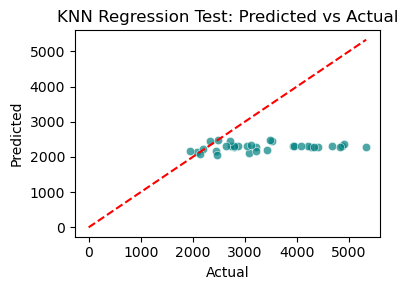

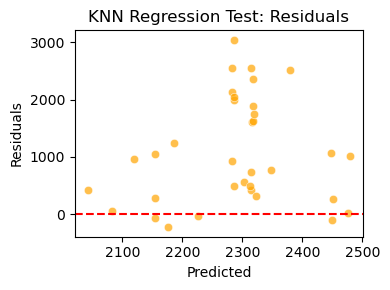

In [111]:
# KNN Regression
knn_params = {
    "n_neighbors": [3, 5, 7, 9],       # Number of neighbors
    "weights": ["uniform", "distance"], # Uniform or distance-based weighting
    "metric": ["minkowski"],            # Use Minkowski distance
    "p": [1, 2]                         # Power parameter: 1=Manhattan, 2=Euclidean
}

best_knn, metrics_train_knn, metrics_val_knn, metrics_test_knn, t_knn = run_full_regression_pipeline(
    KNeighborsRegressor(),
    knn_params,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    model_name="KNN Regression"
)

all_results["KNN"] = {
    "Train": metrics_train_knn,
    "Validation": metrics_val_knn,
    "Test": metrics_test_knn,
    "Train Time": t_knn
}


### 4.3 Decision Tree Regression

=== Decision Tree Regression ===
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
Training Time: 0.31 seconds
Training Metrics: {'MSE': 27088.98778594771, 'RMSE': 164.58732571479405, 'MAE': 95.48785947712419, 'R2': 0.9993717807046215}
Validation Metrics: {'MSE': 2930661.793560606, 'RMSE': 1711.9175779109828, 'MAE': 1353.2954545454545, 'R2': -1.8152509604567824}
Test Metrics: {'MSE': 3142642.9577205884, 'RMSE': 1772.750111471041, 'MAE': 1508.610294117647, 'R2': -2.6021747707902976}


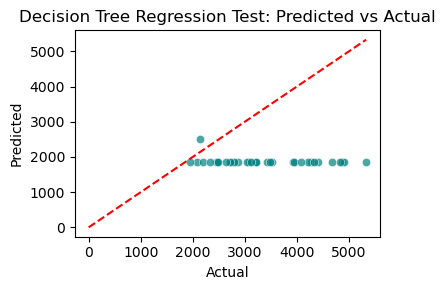

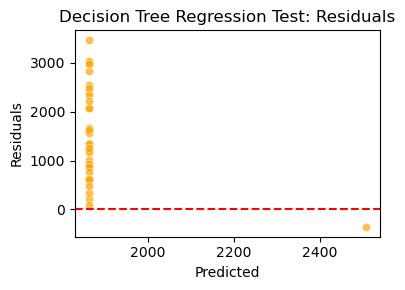

In [112]:
# Decision Tree Regression (expanded hyperparameters)
dt_params = {
    "max_depth": [3, 5, 7, None],          # Maximum depth of the tree
    "min_samples_split": [2, 5, 10],       # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],         # Minimum samples in a leaf node
    "max_features": [None, "sqrt", "log2"] # Maximum features considered for splits
}

best_dt, metrics_train_dt, metrics_val_dt, metrics_test_dt, t_dt = run_full_regression_pipeline(
    DecisionTreeRegressor(random_state=42),
    dt_params,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    model_name="Decision Tree Regression"
)

all_results["DecisionTree"] = {
    "Train": metrics_train_dt,
    "Validation": metrics_val_dt,
    "Test": metrics_test_dt,
    "Train Time": t_dt
}


### 4.4 Summary of Results

In [113]:
# --- Summary Table ---
summary_rows = []
for name, result in all_results.items():
    row = {
        "Model": name,
        "Train Time (s)": result["Train Time"],
        # MSE
        "Train MSE": result["Train"]["MSE"],
        "Val MSE": result["Validation"]["MSE"],
        "Test MSE": result["Test"]["MSE"],
        # RMSE
        "Train RMSE": result["Train"]["RMSE"],
        "Val RMSE": result["Validation"]["RMSE"],
        "Test RMSE": result["Test"]["RMSE"],
        # MAE
        "Train MAE": result["Train"]["MAE"],
        "Val MAE": result["Validation"]["MAE"],
        "Test MAE": result["Test"]["MAE"],
        # R2
        "Train R2": result["Train"]["R2"],
        "Val R2": result["Validation"]["R2"],
        "Test R2": result["Test"]["R2"],
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df.T

,0,1,2,3,4,5
Model,Linear,Ridge,Lasso,ElasticNet,KNN,DecisionTree
Train Time (s),0.122004,0.077672,2.499604,6.408827,0.093688,0.310345
Train MSE,0.0,24217.821015,8307.083167,204799.524771,0.0,27088.987786
Val MSE,21107859.180193,23330993.968793,33318519.692536,2248840.564503,2491447.195318,2930661.793561
Test MSE,93161016.377512,74543053.978961,28881710.275683,25064391.81243,1997494.42377,3142642.957721
Train RMSE,0.0,155.62076,91.143201,452.547815,0.0,164.587326
Val RMSE,4594.329024,4830.216762,5772.21965,1499.613472,1578.431879,1711.917578
Test RMSE,9651.995461,8633.831941,5374.170659,5006.43504,1413.32743,1772.750111
Train MAE,0.0,120.186668,70.735653,360.472428,0.0,95.487859
Val MAE,3677.124162,3897.209411,4528.763579,1257.12504,1276.308268,1353.295455
